In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from keras.models import load_model, Model
from keras.layers import GlobalAveragePooling2D
from MulticoreTSNE import MulticoreTSNE as TSNE
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from keras.applications.mobilenetv2 import MobileNetV2, preprocess_input
from sklearn.decomposition import PCA
import scikitplot as skplt
import matplotlib.pyplot as plt
import umap

/home/yannis/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load data

In [2]:
test = pd.read_csv("test.csv")

In [3]:
size = (224,224)
x_test = []
y_test = []
for row in tqdm(test.iterrows()):
    d = row[1]
    
    image = Image.open("/home/yannis/Developpement/ppd-GAN-for-medical-imaging/dataset-1/data/original/all/" + d["name"])
    img2 = np.array(image.crop((120, 0, 580, 460)).resize(size)).astype(np.float32)
    imgs = preprocess_input(img2)
    
    x_test.append(imgs)
    y_test.append(int(d["label"]))

x_test = np.array(x_test)
y_test = np.array(y_test)

1585it [00:16, 94.74it/s]


## TSNE layer

In [4]:
model = load_model("../models/dataset-1/Comparaison_2/Mobilnet_real-mixgan_n8_3/best_model_epoch.hdf5")

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [31]:
f1 = model.get_layer("Conv1_relu")
md = Model(model.input, f1.output)
pred = md.predict(x_test)
pred = pred.reshape(1585, -1)

In [42]:
pca = PCA()
pca_result = pca.fit(pred)

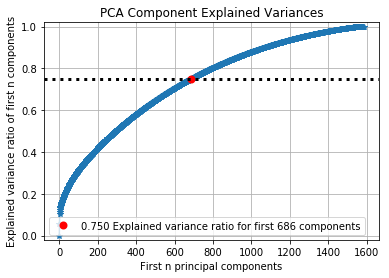

In [43]:
skplt.decomposition.plot_pca_component_variance(pca)
plt.show()

In [55]:
cum = np.cumsum(pca.explained_variance_ratio_,axis=0)

In [58]:
np.where(cum > 0.75)[0][0]

685

In [61]:
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca.components_[:,0:685])

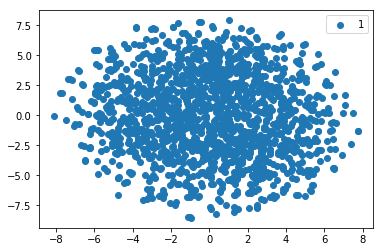

In [75]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], label=1)
plt.legend()
plt.show()

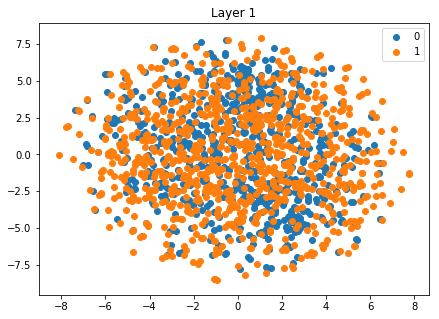

In [83]:
plt.figure(figsize=(7,5))
for cl in range(2):
    indices = np.where(y_test==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.title("Layer 1")
plt.show()

 --------------  block_2_add ---------------------
27


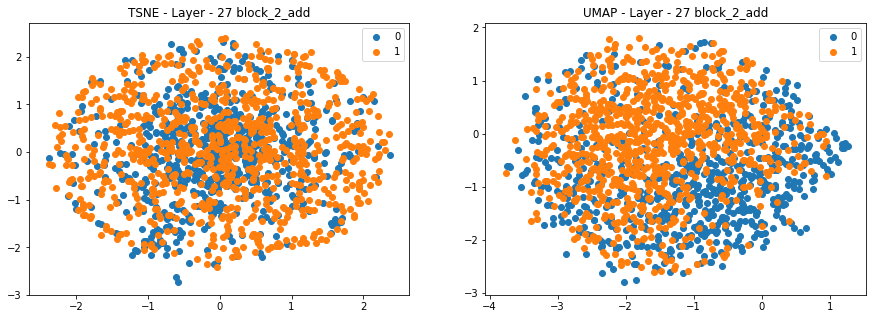

 --------------  block_4_add ---------------------
45


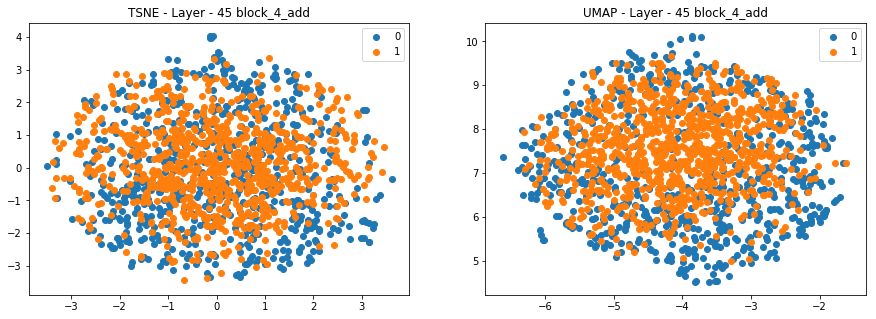

 --------------  block_5_add ---------------------
54


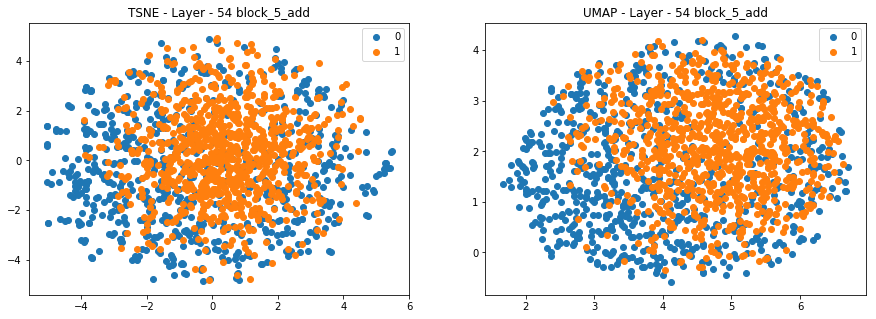

 --------------  block_7_add ---------------------
72


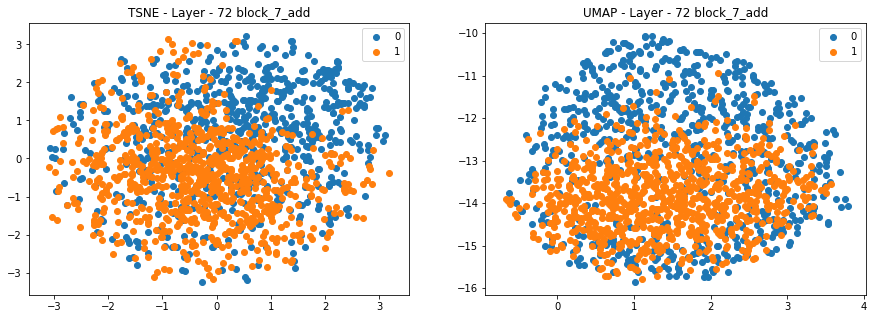

 --------------  block_8_add ---------------------
81


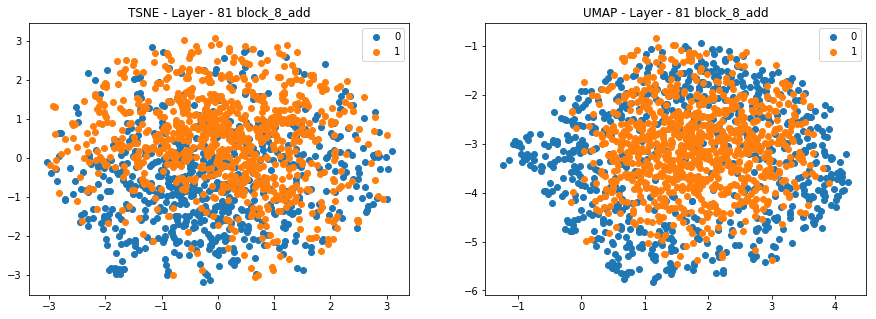

 --------------  block_9_add ---------------------
90


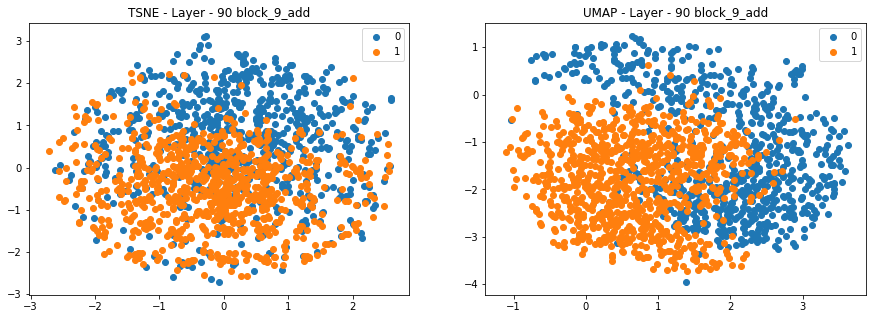

 --------------  block_11_add ---------------------
107


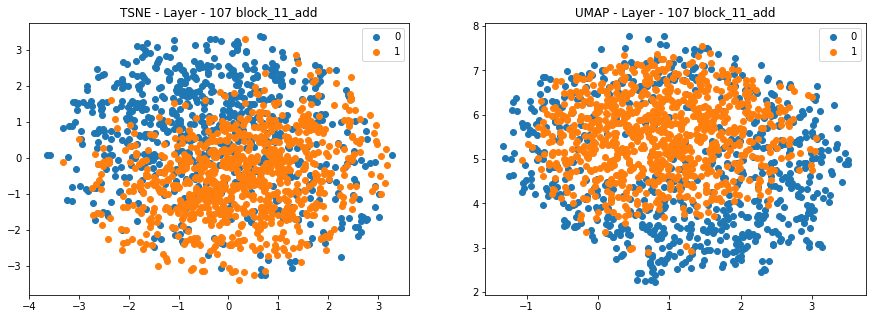

 --------------  block_12_add ---------------------
116


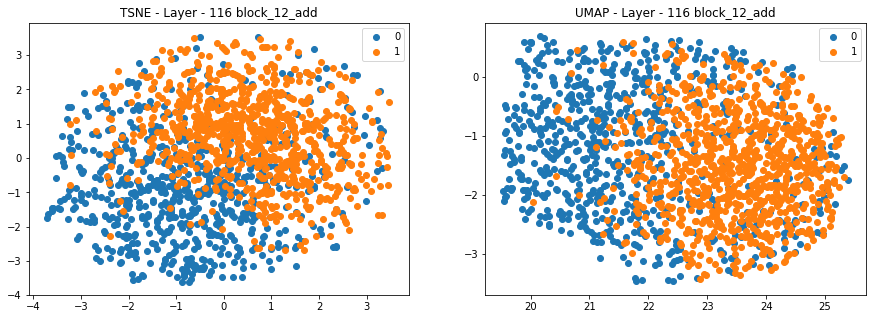

 --------------  block_14_add ---------------------
134


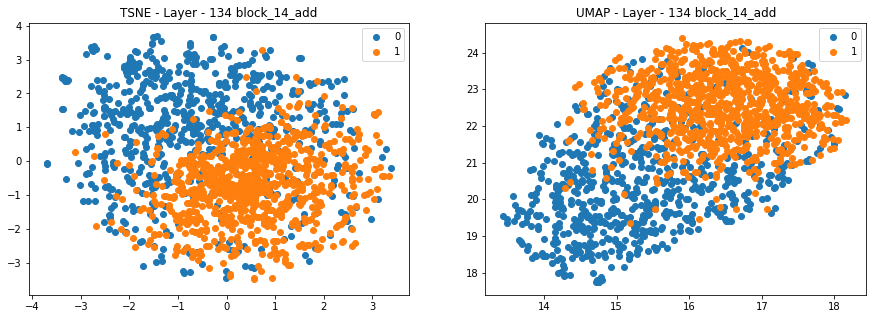

 --------------  block_15_add ---------------------
143


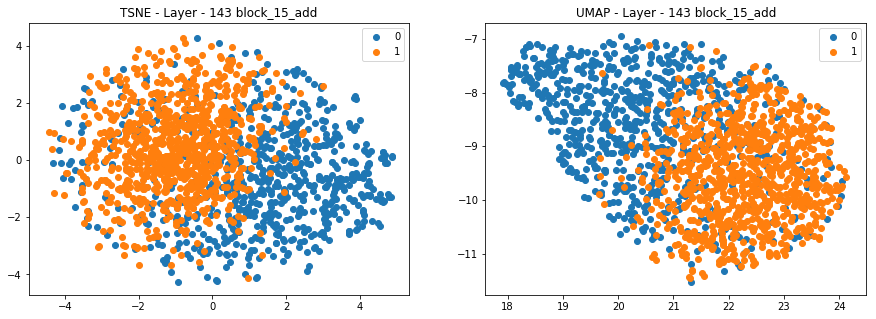

In [35]:
for idx, layer in enumerate(model.layers):
    if "add" in layer.name:
        print(" -------------- ", layer.name, "---------------------")
        print(idx)
        md = Model(model.input, layer.output)
        pred = md.predict(x_test)
        pred = pred.reshape(1585, -1)
        pca = PCA()
        pca.fit(pred)
        
        cum = np.cumsum(pca.explained_variance_ratio_,axis=0)
        n_comp = np.where(cum > 0.75)[0][0]
        
        embedding = umap.UMAP().fit_transform(pca.components_[:,0:n_comp])
        
        tsne = TSNE(n_components=2, verbose = 1)
        tsne_results = tsne.fit_transform(pca.components_[:,0:n_comp])
        
        plt.figure(figsize=(15,5))
        plt.subplot(1, 2, 1)
        plot_figure(tsne_results, y_test, name="TSNE - Layer - "+str(idx)+" "+layer.name)
        plt.subplot(1, 2, 2)
        plot_figure(embedding, y_test, name="UMAP - Layer - "+str(idx)+" "+layer.name)
        plt.show()

 --------------  expanded_conv_project_BN ---------------------
9


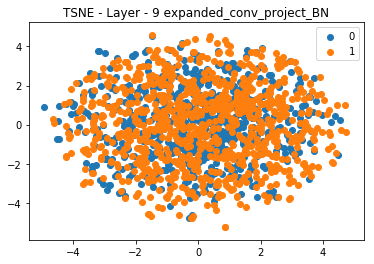

 --------------  block_1_project_BN ---------------------
18


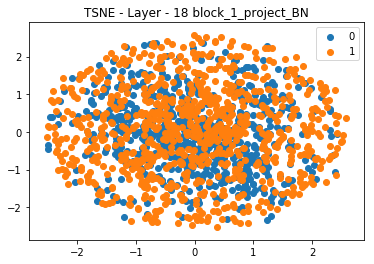

 --------------  block_2_project_BN ---------------------
26


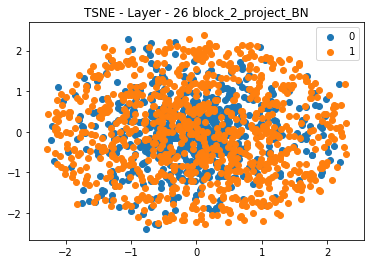

 --------------  block_3_project_BN ---------------------
36


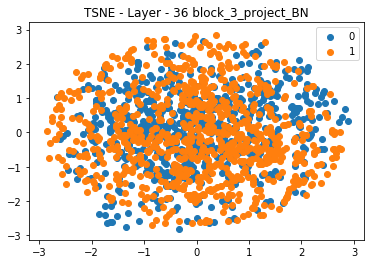

 --------------  block_4_project_BN ---------------------
44


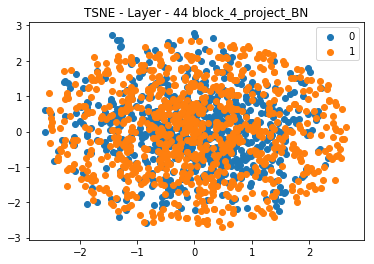

 --------------  block_5_project_BN ---------------------
53


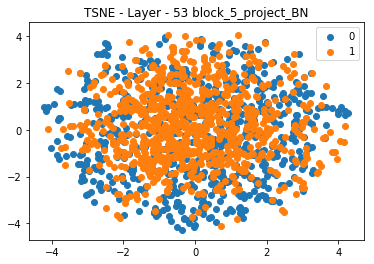

 --------------  block_6_project_BN ---------------------
63


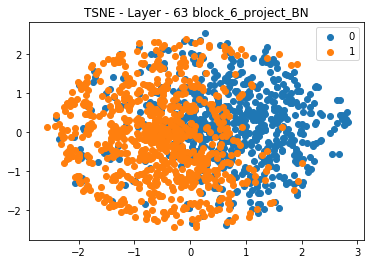

 --------------  block_7_project_BN ---------------------
71


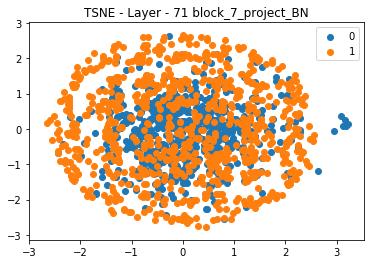

 --------------  block_8_project_BN ---------------------
80


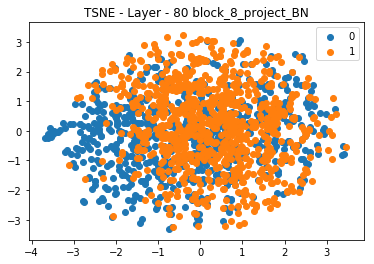

 --------------  block_9_project_BN ---------------------
89


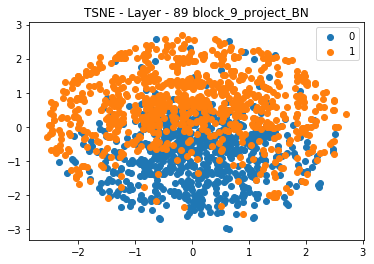

 --------------  block_10_project_BN ---------------------
98


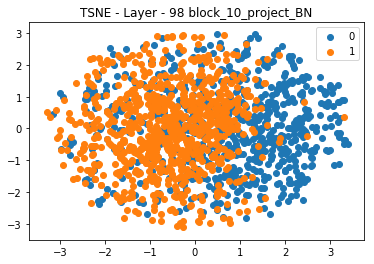

 --------------  block_11_project_BN ---------------------
106


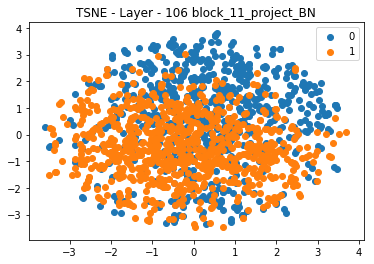

 --------------  block_12_project_BN ---------------------
115


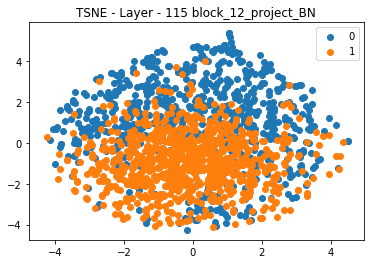

 --------------  block_13_project_BN ---------------------
125


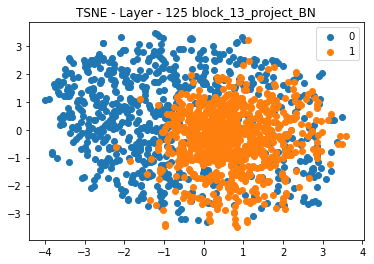

 --------------  block_14_project_BN ---------------------
133


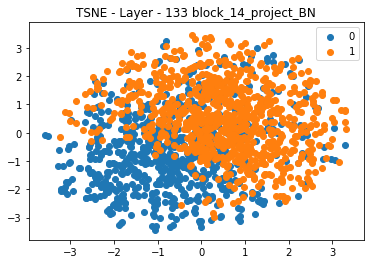

 --------------  block_15_project_BN ---------------------
142


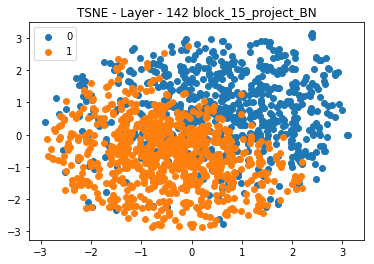

 --------------  block_16_project_BN ---------------------
151


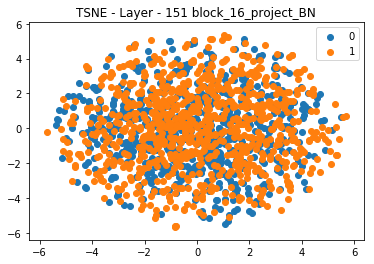

In [9]:
for idx, layer in enumerate(model.layers):
    if "_project_BN" in layer.name:
        print(" -------------- ", layer.name, "---------------------")
        print(idx)
        md = Model(model.input, layer.output)
        pred = md.predict(x_test)
        pred = pred.reshape(1585, -1)
        pca = PCA()
        pca.fit(pred)
        
        cum = np.cumsum(pca.explained_variance_ratio_,axis=0)
        n_comp = np.where(cum > 0.75)[0][0]
        if n_comp > 900:
            n_comp = 900
        tsne = TSNE(n_components=2, verbose = 1)
        tsne_results = tsne.fit_transform(pca.components_[:,0:n_comp])
        
        plot_figure(tsne_results, y_test, name="TSNE - Layer - "+str(idx)+" "+layer.name)
        plt.show()

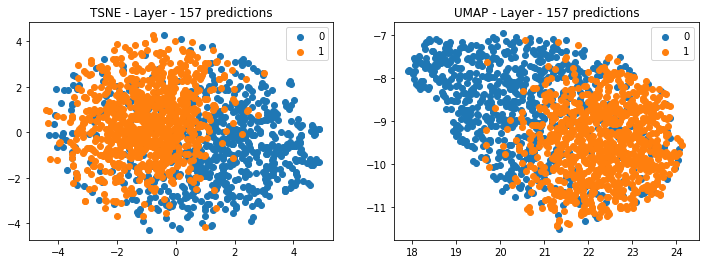

In [43]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_figure(tsne_results, y_test, name="TSNE - Layer - "+str(idx)+" "+layer.name)
plt.subplot(1, 2, 2)
plot_figure(embedding, y_test, name="UMAP - Layer - "+str(idx)+" "+layer.name)
plt.show()

In [6]:
def plot_figure(results, label, name):
    for cl in range(2):
        indices = np.where(label==cl)
        indices = indices[0]
        plt.scatter(results[indices,0], results[indices, 1], label=cl)
    plt.legend()
    plt.title(name)

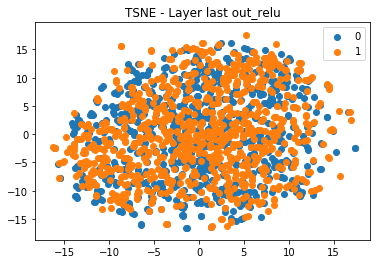

In [11]:
md = Model(model.input, model.get_layer("out_relu").output)
pred = md.predict(x_test)
pred = pred.reshape(1585, -1)
pca = PCA()
pca.fit(pred)

cum = np.cumsum(pca.explained_variance_ratio_,axis=0)
n_comp = np.where(cum > 0.75)[0][0]
if n_comp > 900:
    n_comp = 900
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca.components_[:,0:n_comp])

plot_figure(tsne_results, y_test, name="TSNE - Layer last out_relu")
plt.show()

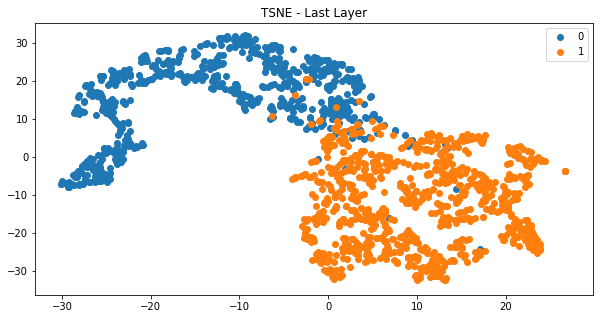

In [26]:
md = Model(model.input, model.get_layer("global_average_pooling2d_1").output)
pred = md.predict(x_test)
pred = pred.reshape(1585, -1)
pca = PCA()
result = pca.fit_transform(pred)

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(result[:,0:n_comp])

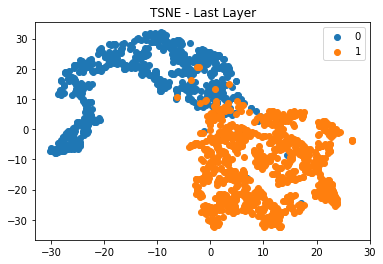

In [30]:
plt.figure(figsize=(6,4))
plot_figure(tsne_results, y_test, name="TSNE - Last Layer")
plt.show()

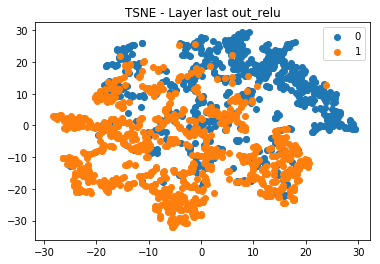

In [44]:
x = GlobalAveragePooling2D()(model.get_layer("Conv1_relu").output)
md = Model(model.input, x)
pred = md.predict(x_test)

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pred)

plot_figure(tsne_results, y_test, name="TSNE - Layer last out_relu")
plt.show()

 --------------  block_2_add ---------------------
27


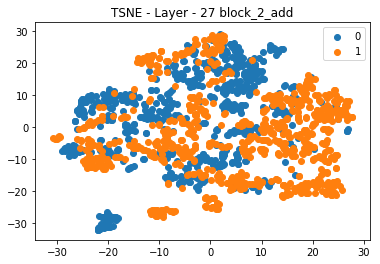

 --------------  block_4_add ---------------------
45


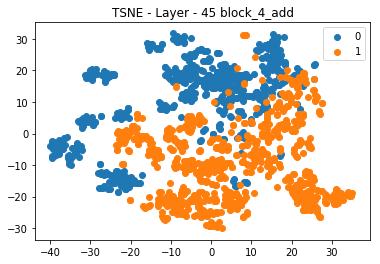

 --------------  block_5_add ---------------------
54


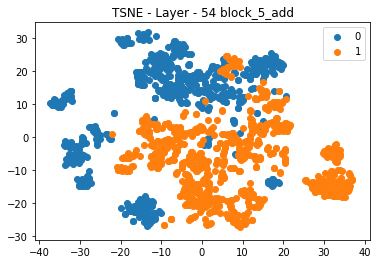

 --------------  block_7_add ---------------------
72


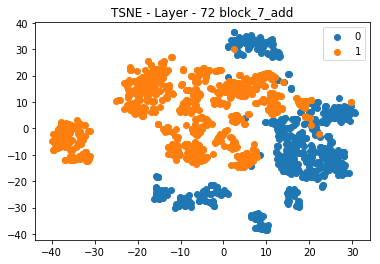

 --------------  block_8_add ---------------------
81


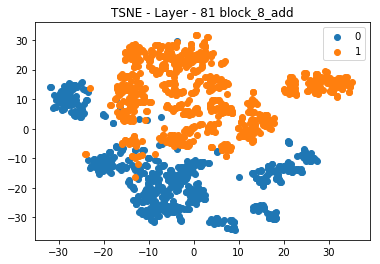

 --------------  block_9_add ---------------------
90


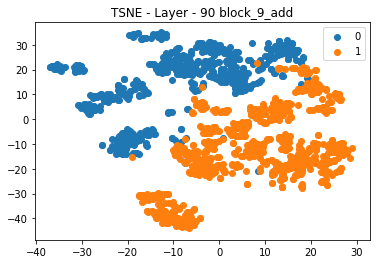

 --------------  block_11_add ---------------------
107


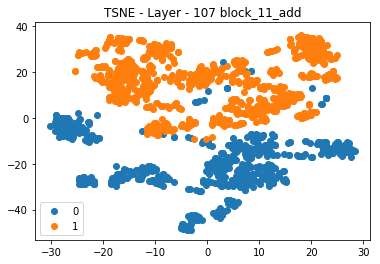

 --------------  block_12_add ---------------------
116


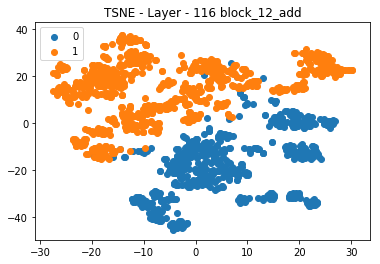

 --------------  block_14_add ---------------------
134


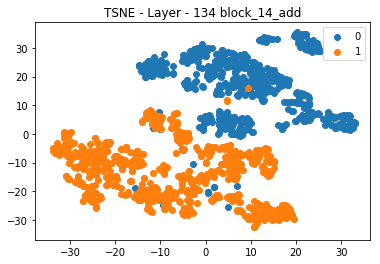

 --------------  block_15_add ---------------------
143


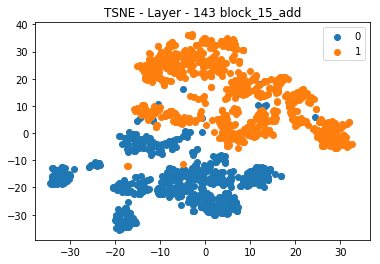

In [46]:
x = GlobalAveragePooling2D()(model.get_layer("Conv1_relu").output)
md = Model(model.input, x)
pred = md.predict(x_test)

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pred)

plot_figure(tsne_results, y_test, name="TSNE - Layer last out_relu")
plt.show()


for idx, layer in enumerate(model.layers):
    if "add" in layer.name:
        print(" -------------- ", layer.name, "---------------------")
        print(idx)
        x = GlobalAveragePooling2D()(layer.output)
        md = Model(model.input, x)
        pred = md.predict(x_test)
        
        tsne = TSNE(n_components=2, verbose = 1)
        tsne_results = tsne.fit_transform(pred)
        
        plt.figure(figsize=(6,4))
        plot_figure(tsne_results, y_test, name="TSNE - Layer - "+str(idx)+" "+layer.name)
        plt.show()

In [74]:
md = Model(model.input, model.get_layer("global_average_pooling2d_1").output)
pred = md.predict(x_test)

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pred)        

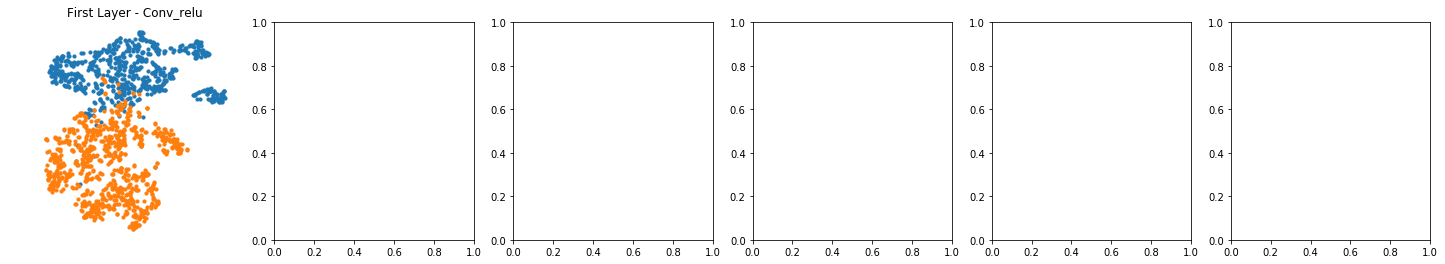

In [ ]:
f, ax = plt.subplots(2, 6)
f.set_size_inches(30, 25)
# ax[0].imshow(img1, cmap='jet')
# ax[0].axis('off')
for i, grad in enumerate(plot_heat[0:6]):
    jet_heatmap = np.uint8(cm.jet(grad)[..., :3] * 255)
    ax[i+1].imshow(overlay(jet_heatmap, img1))
    ax[i+1].axis('off')

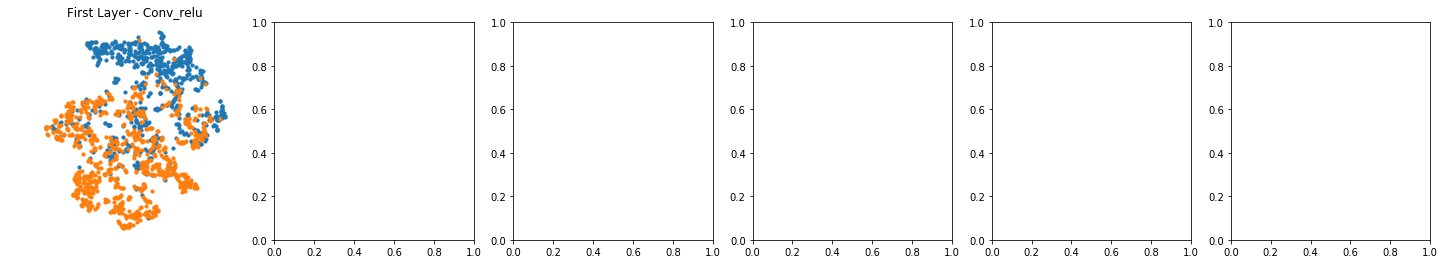

In [53]:
f, ax = plt.subplots(1, 6)
f.set_size_inches(25, 4)
for cl in range(2):
    indices = np.where(y_test==cl)
    indices = indices[0]
    ax[0].scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl, s=10)
ax[0].axis('off')
ax[0].set_title('First Layer - Conv_relu')
plt.show()

In [ ]:
ax

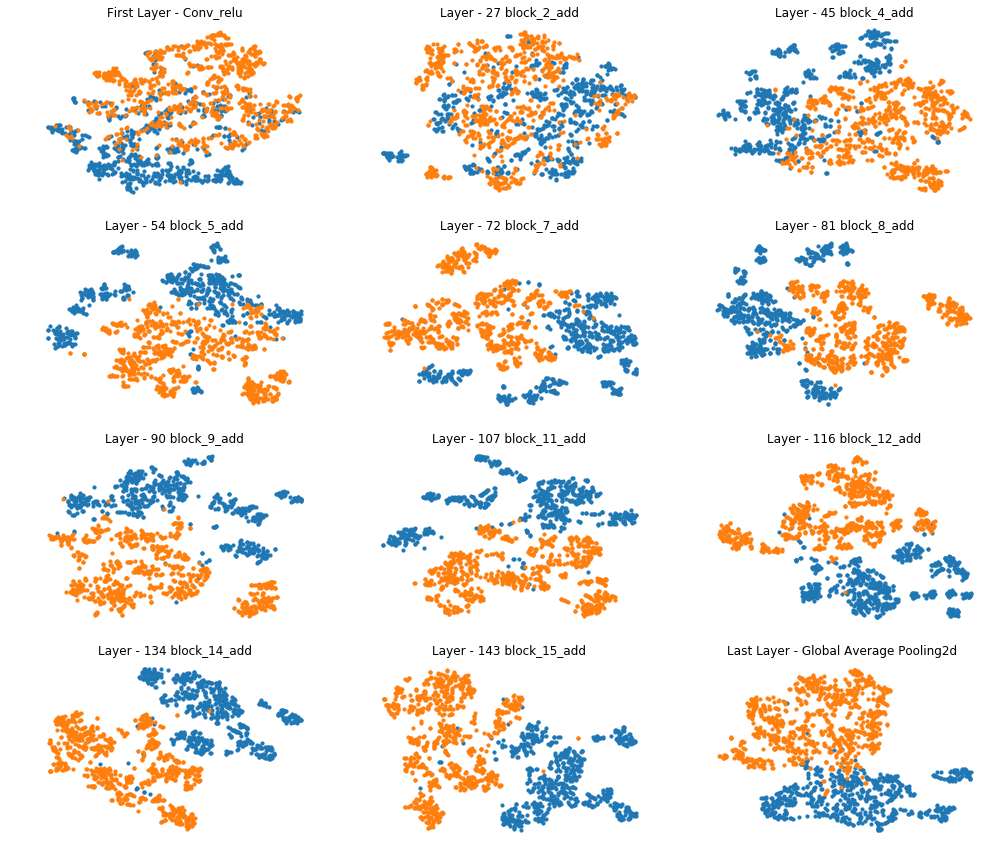

In [77]:
x = GlobalAveragePooling2D()(model.get_layer("Conv1").output)
md = Model(model.input, x)
pred = md.predict(x_test)

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pred)

f, ax = plt.subplots(3, 4)
f.set_size_inches(17, 15)

for cl in range(2):
    indices = np.where(y_test==cl)
    indices = indices[0]
    ax[0][0].scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl, s=10)
ax[0][0].axis('off')
ax[0][0].set_title('First Layer - Conv_relu')

idx_p = 1
idx_l = 0
for idx, layer in enumerate(model.layers):
    if "add" in layer.name:
        name="Layer - "+str(idx)+" "+layer.name
        
        x = GlobalAveragePooling2D()(layer.output)
        md = Model(model.input, x)
        pred = md.predict(x_test)
        
        tsne = TSNE(n_components=2, verbose = 1)
        tsne_results = tsne.fit_transform(pred)
        
        if idx_p == 4:
            idx_p = 0
            idx_l += 1
        
        for cl in range(2):
            indices = np.where(y_test==cl)
            indices = indices[0]
            ax[idx_l][idx_p].scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl, s=10)
        ax[idx_l][idx_p].axis('off')
        ax[idx_l][idx_p].set_title(name)
        
        idx_p += 1
        

        
md = Model(model.input, model.get_layer("global_average_pooling2d_1").output)
pred = md.predict(x_test)

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pred)

for cl in range(2):
    indices = np.where(y_test==cl)
    indices = indices[0]
    ax[idx_l][idx_p].scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl, s=10)
ax[idx_l][idx_p].axis('off')
ax[idx_l][idx_p].set_title("Last Layer - Global Average Pooling2d ")
        
        

plt.show()

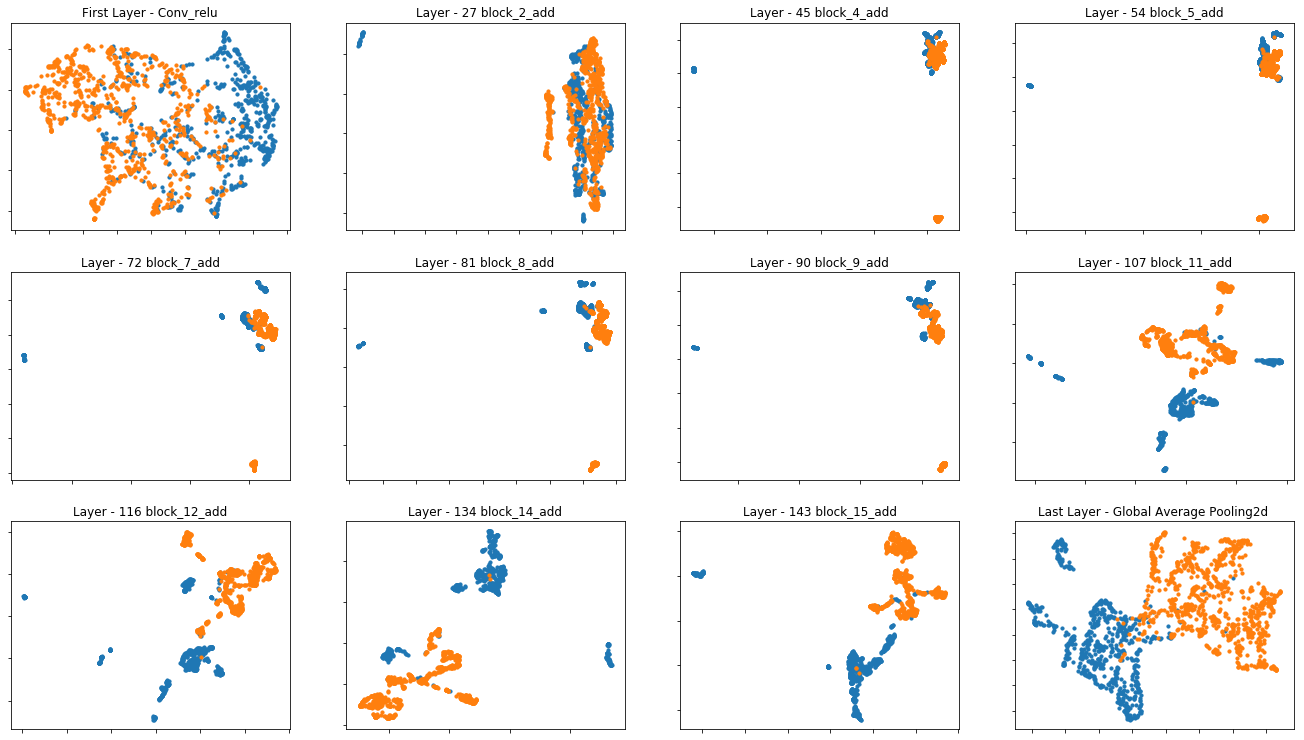

In [88]:
x = GlobalAveragePooling2D()(model.get_layer("Conv1").output)
md = Model(model.input, x)
pred = md.predict(x_test)

tsne_results = umap.UMAP().fit_transform(pred)

f, ax = plt.subplots(3, 4)
f.set_size_inches(23, 13)

for cl in range(2):
    indices = np.where(y_test==cl)
    indices = indices[0]
    ax[0][0].scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl, s=10)
ax[0][0].set_yticklabels([])
ax[0][0].set_xticklabels([])
ax[0][0].set_title('First Layer - Conv_relu')

idx_p = 1
idx_l = 0
for idx, layer in enumerate(model.layers):
    if "add" in layer.name:
        name="Layer - "+str(idx)+" "+layer.name
        
        x = GlobalAveragePooling2D()(layer.output)
        md = Model(model.input, x)
        pred = md.predict(x_test)
        
        tsne_results = umap.UMAP().fit_transform(pred)
#         tsne = TSNE(n_components=2, verbose = 1)
#         tsne_results = tsne.fit_transform(pred)
        
        if idx_p == 4:
            idx_p = 0
            idx_l += 1
        
        for cl in range(2):
            indices = np.where(y_test==cl)
            indices = indices[0]
            ax[idx_l][idx_p].scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl, s=10)
        ax[idx_l][idx_p].set_yticklabels([])
        ax[idx_l][idx_p].set_xticklabels([])
        ax[idx_l][idx_p].set_title(name)
        
        idx_p += 1
        

        
md = Model(model.input, model.get_layer("global_average_pooling2d_1").output)
pred = md.predict(x_test)

tsne_results = umap.UMAP().fit_transform(pred)

for cl in range(2):
    indices = np.where(y_test==cl)
    indices = indices[0]
    ax[idx_l][idx_p].scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl, s=10)
# ax[idx_l][idx_p].axis('off')
ax[idx_l][idx_p].set_title("Last Layer - Global Average Pooling2d ")
ax[idx_l][idx_p].set_yticklabels([])
ax[idx_l][idx_p].set_xticklabels([])
        
        

plt.show()

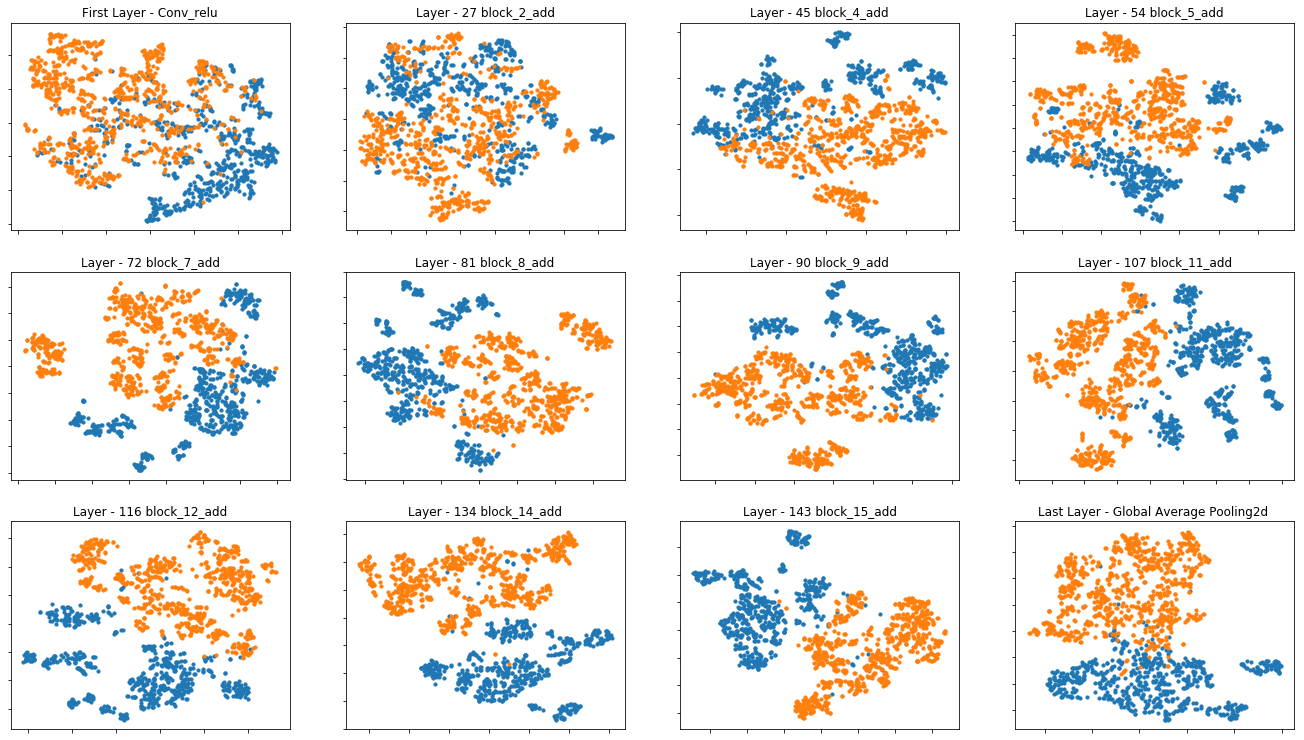

In [89]:
x = GlobalAveragePooling2D()(model.get_layer("Conv1").output)
md = Model(model.input, x)
pred = md.predict(x_test)

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pred)

f, ax = plt.subplots(3, 4)
f.set_size_inches(23, 13)

for cl in range(2):
    indices = np.where(y_test==cl)
    indices = indices[0]
    ax[0][0].scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl, s=10)
ax[0][0].set_yticklabels([])
ax[0][0].set_xticklabels([])
ax[0][0].set_title('First Layer - Conv_relu')

idx_p = 1
idx_l = 0
for idx, layer in enumerate(model.layers):
    if "add" in layer.name:
        name="Layer - "+str(idx)+" "+layer.name
        
        x = GlobalAveragePooling2D()(layer.output)
        md = Model(model.input, x)
        pred = md.predict(x_test)
        
#         tsne_results = umap.UMAP().fit_transform(pred)
        tsne = TSNE(n_components=2, verbose = 1)
        tsne_results = tsne.fit_transform(pred)
        
        if idx_p == 4:
            idx_p = 0
            idx_l += 1
        
        for cl in range(2):
            indices = np.where(y_test==cl)
            indices = indices[0]
            ax[idx_l][idx_p].scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl, s=10)
        ax[idx_l][idx_p].set_yticklabels([])
        ax[idx_l][idx_p].set_xticklabels([])
        ax[idx_l][idx_p].set_title(name)
        
        idx_p += 1
        

        
md = Model(model.input, model.get_layer("global_average_pooling2d_1").output)
pred = md.predict(x_test)

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pred)

for cl in range(2):
    indices = np.where(y_test==cl)
    indices = indices[0]
    ax[idx_l][idx_p].scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl, s=10)
# ax[idx_l][idx_p].axis('off')
ax[idx_l][idx_p].set_title("Last Layer - Global Average Pooling2d ")
ax[idx_l][idx_p].set_yticklabels([])
ax[idx_l][idx_p].set_xticklabels([])
        
        

plt.show()

In [9]:
def plot_figure(ax, results, label, name):
    for cl in range(2):
        indices = np.where(label==cl)
        indices = indices[0]
        ax.scatter(results[indices,0], results[indices, 1], label=cl)
    ax.legend()
    ax.title(name)
    ax.axis('off')